In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
import keras.backend.tensorflow_backend as K

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)
K.set_session(session)
K.get_session().run(tf.global_variables_initializer())


from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

import keras.backend as K
import matplotlib.pyplot as plt
import sys
import numpy as np
from skimage.io import imread

%matplotlib inline

(96, 96, 3)

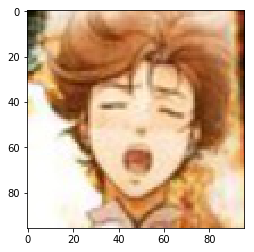

In [15]:
img = imread('AnimeDataset/faces/sub/121.jpg')
plt.imshow(img)
img.shape

In [16]:
IMG_SIZE = 64
G_IN_DIM = 100

g_in = Input((G_IN_DIM,))
g_x = Dense(128 * 8 * 8, activation="relu")(g_in)

g_x = Reshape((8, 8,128))(g_x)
g_x = UpSampling2D()(g_x)

g_x = Conv2D(128, kernel_size=4, padding="same")(g_x)
g_x = BatchNormalization(momentum=0.8)(g_x)
g_x = Activation("relu")(g_x)

g_x = UpSampling2D()(g_x)
g_x = Conv2D(64, kernel_size=4, padding="same")(g_x)
g_x = BatchNormalization(momentum=0.8)(g_x)
g_x = Activation("relu")(g_x)

g_x = UpSampling2D()(g_x)
g_x = Conv2D(32, kernel_size=4, padding="same")(g_x)
g_x = BatchNormalization(momentum=0.8)(g_x)
g_x = Activation("relu")(g_x)

g_x = Conv2D(3, kernel_size=4, padding="same")(g_x)
g_x = Activation("tanh")(g_x)

generator = Model(inputs=g_in, outputs=g_x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
activation_5 (Activation)    (None, 16, 16, 128)       0         
__________

In [17]:
d_in = Input((IMG_SIZE, IMG_SIZE, 3))
d_x = Conv2D(16, kernel_size=3, strides=2, padding="same")(d_in)
d_x = LeakyReLU(alpha=0.2)(d_x)

d_x = Dropout(0.25)(d_x)
d_x = Conv2D(32, kernel_size=3, strides=2, padding="same")(d_x)
# d_x = ZeroPadding2D(padding=((0,1),(0,1)))(d_x)
d_x = BatchNormalization(momentum=0.8)(d_x)
d_x = LeakyReLU(alpha=0.2)(d_x)

d_x = Dropout(0.25)(d_x)
d_x = Conv2D(64, kernel_size=3, strides=2, padding="same")(d_x)
d_x = BatchNormalization(momentum=0.8)(d_x)
d_x = LeakyReLU(alpha=0.2)(d_x)
d_x = Dropout(0.25)(d_x)

d_x = Conv2D(128, kernel_size=3, strides=1, padding="same")(d_x)
d_x = BatchNormalization(momentum=0.8)(d_x)
d_x = LeakyReLU(alpha=0.2)(d_x)
d_x = Dropout(0.25)(d_x)
d_x = Flatten()(d_x)
d_x = Dense(1)(d_x)

critic = Model(d_in, d_x)
critic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 32)        0         
__________

In [18]:
# y_pos = -1, y_neg = 1


# For critic, the predicted labels are reversed
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

optimizer = RMSprop(lr=0.00005)
critic.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])


# For the combined model we will only train the generator
critic.trainable = False
g_valid = critic(g_x)
dg = Model(g_in, g_valid)
dg.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])

In [19]:
dg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
activation_5 (Activation)    (None, 16, 16, 128)       0         
__________

In [20]:
epochs = 10000
critic_repeat_times = 5
batch_size = 32
seed = 1
clip_value = 0.01

In [21]:
train_datagen = ImageDataGenerator(preprocessing_function=lambda x: (x / 127.5) -1)

train_generator = train_datagen.flow_from_directory(
        'AnimeDataset/faces/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode=None,
        seed=seed)

Found 33431 images belonging to 1 classes.


In [22]:
def generate_samples(save=False):

    zz = np.random.normal(0., 1., (100, G_IN_DIM))
    generated_images = generator.predict(zz)

    rr = []
    for c in range(10):
        rr.append(
            np.concatenate(generated_images[c * 10:(1 + c) * 10]).reshape(
                IMG_SIZE * 10, IMG_SIZE, 3))
    img = np.hstack(rr)

#     if save:
#         plt.imsave(OUT_DIR + '/samples_%07d.png' % n, img, cmap=plt.cm.gray)
    return img

In [30]:
# write tensorboard summaries
sw = tf.summary.FileWriter('log/')

img_to_show = tf.placeholder(tf.float32, (IMG_SIZE * 10, IMG_SIZE * 10, 3))
image_op = tf.summary.image('samples', tf.expand_dims(img_to_show, axis=0))

def update_tb_summary(step, d_loss, g_loss, write_sample_images=True):

    s = tf.Summary()
    v = s.value.add()
    v.simple_value = d_loss
    v.tag = 'd_loss'
    
    v = s.value.add()
    v.simple_value = g_loss
    v.tag = 'g_loss'

    # generated image
    if write_sample_images:
        img = generate_samples(save=False)
        s.MergeFromString(session.run(image_op, feed_dict={img_to_show: img}))

    sw.add_summary(s, step)
    sw.flush()

In [ ]:
real_label = -np.ones((batch_size, 1))
fake_label = np.ones_like(real_label)

for ep in range(epochs):
    for _ in range(critic_repeat_times):
        real_imgs = next(train_generator)
        while real_imgs.shape[0] != batch_size:
            real_imgs = next(train_generator)
        
        z = np.random.normal(0, 1, (batch_size, G_IN_DIM))

        fake_imgs = generator.predict(z)

        d_loss_real = critic.train_on_batch(real_imgs, real_label)
        d_loss_fake = critic.train_on_batch(fake_imgs, fake_label)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Clip critic weights
        for l in critic.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -clip_value, clip_value) for w in weights]
            l.set_weights(weights)

    g_loss = dg.train_on_batch(z, real_label)

    # Plot the progress
    if ep % 10 == 0:
        print("%d [D loss: %f] [G loss: %f]" %
              (ep, 1 - d_loss[0], 1 - g_loss[0]))

    # If at save interval => save generated image samples
    if ep % 100 == 0:
        update_tb_summary(ep, 1 - d_loss[0], 1 - g_loss[0])

/home/bigdata/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.999986] [G loss: 1.000053]
10 [D loss: 0.999952] [G loss: 1.000048]
20 [D loss: 0.999973] [G loss: 1.000052]
30 [D loss: 0.999965] [G loss: 1.000044]
40 [D loss: 0.999957] [G loss: 1.000068]
50 [D loss: 0.999963] [G loss: 1.000054]
60 [D loss: 0.999974] [G loss: 1.000037]
70 [D loss: 0.999967] [G loss: 1.000044]
80 [D loss: 0.999969] [G loss: 1.000053]
90 [D loss: 0.999990] [G loss: 1.000042]
100 [D loss: 0.999979] [G loss: 1.000038]
110 [D loss: 0.999975] [G loss: 1.000049]
120 [D loss: 0.999975] [G loss: 1.000058]
130 [D loss: 0.999984] [G loss: 1.000055]
140 [D loss: 0.999994] [G loss: 1.000057]
150 [D loss: 0.999985] [G loss: 1.000078]
160 [D loss: 0.999990] [G loss: 1.000056]
170 [D loss: 0.999995] [G loss: 1.000052]
180 [D loss: 1.000003] [G loss: 1.000033]
190 [D loss: 0.999990] [G loss: 1.000048]
200 [D loss: 0.999984] [G loss: 1.000069]
210 [D loss: 1.000016] [G loss: 1.000076]
220 [D loss: 1.000011] [G loss: 1.000055]
230 [D loss: 1.000014] [G loss: 1.000047]
240

1940 [D loss: 0.999974] [G loss: 1.000455]
1950 [D loss: 0.999976] [G loss: 1.000421]
1960 [D loss: 0.999947] [G loss: 1.000313]
1970 [D loss: 0.999961] [G loss: 1.000302]
1980 [D loss: 0.999950] [G loss: 1.000279]
1990 [D loss: 0.999959] [G loss: 1.000181]
2000 [D loss: 1.000004] [G loss: 1.000103]
2010 [D loss: 1.000122] [G loss: 1.000082]
2020 [D loss: 1.000043] [G loss: 1.000190]
2030 [D loss: 1.000018] [G loss: 1.000530]
2040 [D loss: 1.000026] [G loss: 1.000733]
2050 [D loss: 1.000057] [G loss: 1.000555]
2060 [D loss: 1.000050] [G loss: 1.000481]
2070 [D loss: 0.999997] [G loss: 1.000663]
2080 [D loss: 1.000043] [G loss: 1.000151]
2090 [D loss: 1.000076] [G loss: 1.000038]
2100 [D loss: 0.999940] [G loss: 0.999966]
2110 [D loss: 0.999867] [G loss: 1.000268]
2120 [D loss: 0.999920] [G loss: 1.000308]
2130 [D loss: 0.999991] [G loss: 1.000228]
2140 [D loss: 0.999969] [G loss: 1.000275]
2150 [D loss: 0.999988] [G loss: 1.000081]
2160 [D loss: 0.999988] [G loss: 1.000128]
2170 [D los

3850 [D loss: 0.999967] [G loss: 1.000047]
3860 [D loss: 0.999964] [G loss: 1.000067]
3870 [D loss: 0.999966] [G loss: 1.000059]
3880 [D loss: 0.999969] [G loss: 1.000056]
3890 [D loss: 0.999970] [G loss: 1.000049]
3900 [D loss: 0.999973] [G loss: 1.000049]
3910 [D loss: 0.999969] [G loss: 1.000068]
3920 [D loss: 0.999967] [G loss: 1.000046]
3930 [D loss: 0.999961] [G loss: 1.000056]
3940 [D loss: 0.999968] [G loss: 1.000060]
3950 [D loss: 0.999967] [G loss: 1.000062]
3960 [D loss: 0.999968] [G loss: 1.000056]
3970 [D loss: 0.999962] [G loss: 1.000071]
3980 [D loss: 0.999974] [G loss: 1.000063]
3990 [D loss: 0.999975] [G loss: 1.000075]
4000 [D loss: 0.999966] [G loss: 1.000073]
4010 [D loss: 0.999961] [G loss: 1.000057]
4020 [D loss: 0.999974] [G loss: 1.000048]
4030 [D loss: 0.999963] [G loss: 1.000076]
4040 [D loss: 0.999965] [G loss: 1.000056]
4050 [D loss: 0.999961] [G loss: 1.000070]
4060 [D loss: 0.999967] [G loss: 1.000056]
4070 [D loss: 0.999971] [G loss: 1.000055]
4080 [D los

In [53]:
real_imgs = next(train_generator)
real_imgs.shape

(32, 64, 64, 3)